In [39]:
import os
from PIL import Image
import numpy as np
import pandas as pd
import torch
from torchvision import models
from torchvision import transforms
from torchvision.models import resnet50, ResNet50_Weights
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as pltb
import shutil
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
from sklearn.metrics import calinski_harabasz_score
from sklearn.metrics import silhouette_score

In [329]:
source_dirs = ["images_all", "images_rendered_mermaid", "diagrams/plantuml/images_rendered_plantuml"]
target_dir = "all_diagrams_clustering"
os.makedirs(target_dir, exist_ok=True)

for folder in source_dirs:
    for file in os.listdir(folder):
        src_path = os.path.join(folder, file)

        # Skip if it's not a file (e.g., a directory)
        if not os.path.isfile(src_path):
            continue

        base, ext = os.path.splitext(file)
        dest_path = os.path.join(target_dir, file)

        # Avoid overwriting if file already exists
        i = 1
        while os.path.exists(dest_path):
            dest_path = os.path.join(target_dir, f"{base}_{i}{ext}")
            i += 1

        shutil.copy(src_path, dest_path)

print(f"Combined contents of {len(source_dirs)} folders into '{target_dir}'")

Combined contents of 3 folders into 'all_diagrams_clustering'


In [347]:
image_dir = "all_diagrams_clustering"
count = sum(
    1 for f in os.listdir(image_dir)
    if f.lower().endswith((".png", ".jpg", ".jpeg", ".svg"))
)

print(f"Total images in '{image_dir}': {count}")

Total images in 'all_diagrams_clustering': 3570


In [ ]:
# Load Pretrained Model (ResNet50)
model = models.resnet50(weights=ResNet50_Weights.DEFAULT)
model = torch.nn.Sequential(*list(model.children())[:-1])  # remove classifier
model.eval()

# Image Preprocessing
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

# Embedding Function
def get_image_embedding(image_path):
    img = Image.open(image_path).convert("RGB")
    img_tensor = transform(img).unsqueeze(0)
    with torch.no_grad():
        embedding = model(img_tensor).squeeze().numpy()  # shape: (2048,)
    return embedding


# Process Directory
def process_image_directory(img_dir):
    image_paths = [os.path.join(img_dir, fname)
                   for fname in os.listdir(img_dir)
                   if fname.lower().endswith(('.png', '.jpg', '.jpeg'))]

    embeddings = []
    filenames = []

    for path in image_paths:
        try:
            emb = get_image_embedding(path)
            embeddings.append(emb)
            filenames.append(os.path.basename(path))
        except Exception as e:
            print(f"Error processing {path}: {e}")

    return filenames, np.array(embeddings)

# Run PCA
def compute_pca(embeddings, show_plot=True):
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(embeddings)

    pca_full = PCA().fit(X_scaled)
    cumvar = np.cumsum(pca_full.explained_variance_ratio_)

    if show_plot:
        plt.figure(figsize=(8, 5))
        plt.plot(cumvar, marker='o')
        plt.axhline(y=0.90, color='r', linestyle='--')
        plt.xlabel("Number of Components")
        plt.ylabel("Cumulative Explained Variance")
        plt.title("PCA Explained Variance")
        plt.grid(True)
        plt.show()

    n_components_90 = np.argmax(cumvar >= 0.90) + 1
    pca = PCA(n_components=n_components_95)
    X_pca = pca.fit_transform(X_scaled)

    return X_pca, n_components_90, scaler

# Run Pipeline
def run_pipeline(image_dir):
    filenames, embeddings = process_image_directory(image_dir)
    X_pca, n_components_used, scaler = compute_pca(embeddings, show_plot=True)

    df = pd.DataFrame({
        'filename': filenames,
        'pca_x': X_pca[:, 0],
        'pca_y': X_pca[:, 1],
    })
    return df, X_pca, n_components_used, embeddings

image_dir = "all_diagrams_clustering"
df_pca, X_pca, n_components_used, embeddings = run_pipeline(image_dir)

print(f"Used {n_components_used} PCA components to retain 90% variance.")
print(df_pca.head())


/Users/ellabrady/.pyenv/versions/3.11.6/lib/python3.11/site-packages/PIL/Image.py:1054: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


In [374]:
# Run t-SNE using pca results
tsne = TSNE(n_components=2, perplexity=40, learning_rate=200, init='pca', n_iter=1000, random_state=42)
X_tsne = tsne.fit_transform(X_pca)

/Users/ellabrady/.pyenv/versions/3.11.6/lib/python3.11/site-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


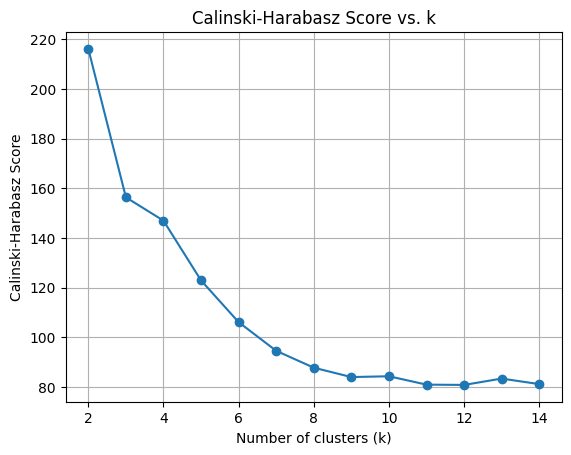

<Figure size 640x480 with 0 Axes>

In [400]:
# Calinski-Harabasz Score Vs K
k_range = range(2, 15)
ch_scores = []
for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    labels = kmeans.fit_predict(X_pca)
    score = calinski_harabasz_score(X_pca, labels)
    ch_scores.append(score)

plt.plot(k_range, ch_scores, marker='o')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Calinski-Harabasz Score')
plt.title('Calinski-Harabasz Score vs. k')
plt.grid(True)
plt.show()
plt.savefig("calinskiharabaz_plot.png")

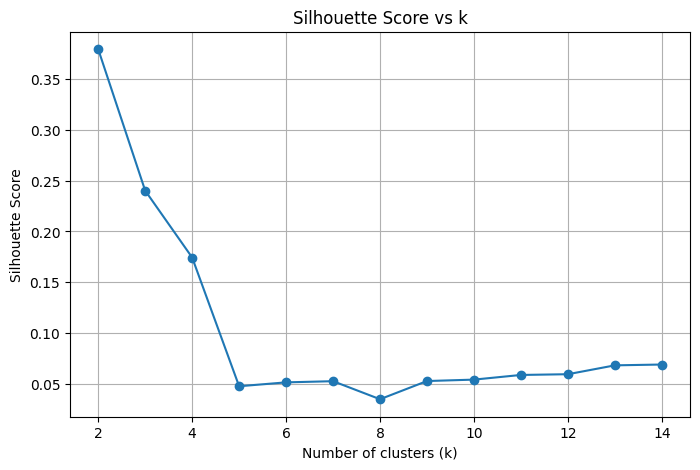

<Figure size 640x480 with 0 Axes>

In [402]:
# Silhouette Score Vs K
scores = []
for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    labels = kmeans.fit_predict(X_pca)
    score = silhouette_score(X_pca, labels)
    scores.append(score)

plt.figure(figsize=(8, 5))
plt.plot(k_range, scores, marker='o')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score vs k')
plt.grid(True)
plt.show()
plt.savefig("silhouettescore_plot.png")

In [380]:
# Run KMeans
kmeans = KMeans(n_clusters=4, random_state=42)
labels = kmeans.fit_predict(X_pca)

/var/folders/fq/c15cnp3j5wq7c495n4y98xnc0000gn/T/ipykernel_60022/350948605.py:7: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('tab10', num_clusters)


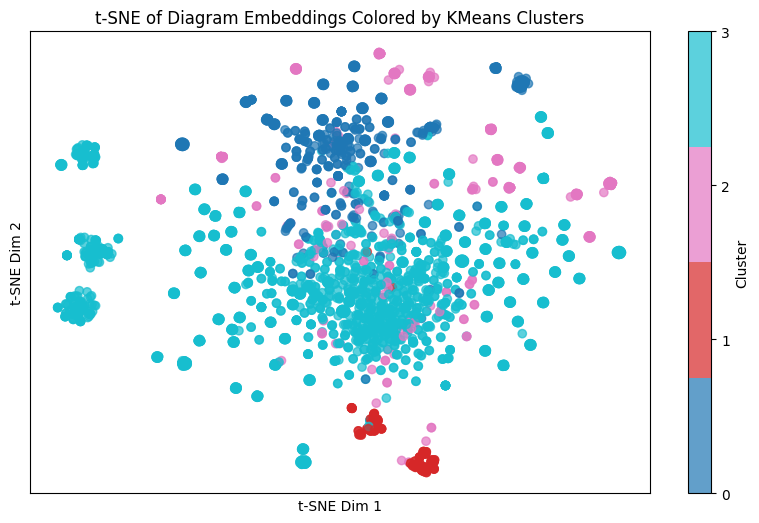

In [382]:
# Plot clusters in tsne space
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as mcolors

num_clusters = len(set(labels))
cmap = cm.get_cmap('tab10', num_clusters)
norm = mcolors.Normalize(vmin=0, vmax=num_clusters - 1)

plt.figure(figsize=(10, 6))
sc = plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=labels, cmap=cmap, norm=norm, alpha=0.7)
plt.title("t-SNE of Diagram Embeddings Colored by KMeans Clusters")
plt.xlabel("t-SNE Dim 1")
plt.ylabel("t-SNE Dim 2")
plt.xticks([])
plt.yticks([]) 
plt.grid(True)
cbar = plt.colorbar(sc, ticks=range(num_clusters))
cbar.set_label('Cluster')
plt.show()

In [390]:
# Add labels to images
from collections import defaultdict

def get_image_paths(directory="all_diagrams_clustering", extensions=('.png', '.jpg', '.jpeg')):

    image_paths = [
        os.path.join(directory, fname)
        for fname in os.listdir(directory)
        if fname.lower().endswith(extensions)
    ]
    return sorted(image_paths)

image_paths = get_image_paths()


clustered_images = defaultdict(list)
for path, label in zip(image_paths, labels):
    clustered_images[label].append(path)

# Test
for img_path in clustered_images[0][:10]:
    print(img_path)

all_diagrams_clustering/0002_mermaid_diagram_384.png
all_diagrams_clustering/0006_mermaid_diagram_353.png
all_diagrams_clustering/0012_mermaid_diagram_1493.png
all_diagrams_clustering/0022_mermaid_diagram_1450.png
all_diagrams_clustering/0041_mermaid_diagram_4.png
all_diagrams_clustering/0043_mermaid_diagram_582.png
all_diagrams_clustering/0044_mermaid_diagram_1054.png
all_diagrams_clustering/0052_mermaid_diagram_555.png
all_diagrams_clustering/0063_mermaid_diagram_1055.png
all_diagrams_clustering/0079_mermaid_diagram_622.png


In [392]:
# Save to cluster directorys
def save_cluster_images(clustered_images, output_dir="clustered_images"):
    os.makedirs(output_dir, exist_ok=True)

    for cluster_id, img_paths in clustered_images.items():
        cluster_folder = os.path.join(output_dir, f"cluster_{cluster_id}")
        os.makedirs(cluster_folder, exist_ok=True)

        for path in img_paths:
            try:
                filename = os.path.basename(path)
                destination = os.path.join(cluster_folder, filename)
                shutil.copy(path, destination)
            except Exception as e:
                print(f"Error copying {path}: {e}")

save_cluster_images(clustered_images, output_dir="output_clusters")


In [331]:
# Delete images that are not data model diagrams
target_dir = "all"
target_phrase = "bilzinet_Traffic-state-reconstruction"
target_phrase_2 = "ambpro_modelio-jdl-studio"
target_phrase_3 = "logo"
target_phrase_4 = "icon"
target_phrase_5 = "arrow"
target_phrase_6 = "dogaoz_SocialNetworkAppForAndroid"
target_phrase_7 = "TrevorDArcyEvans"
target_phrase_8 = "amaurea_model"
target_phrase_9 = "charlesnchr"
target_phrase_10 = "guanzhongheng"
target_phrase_11 = "karanamrahul"
target_phrase_12 = "kristijanbartol"


for filename in os.listdir(target_dir):
    if target_phrase in filename:
        file_path = os.path.join(target_dir, filename)
        if os.path.isfile(file_path): 
            os.remove(file_path)
            print(f"Deleted: {file_path}")

In [393]:
output_dir = "output_clusters"
for cluster_name in os.listdir(output_dir):
    cluster_path = os.path.join(output_dir, cluster_name)
    if os.path.isdir(cluster_path):
        num_files = len([
            f for f in os.listdir(cluster_path)
            if os.path.isfile(os.path.join(cluster_path, f))
        ])
        print(f"{cluster_name}: {num_files} files")

cluster_1: 138 files
cluster_0: 669 files
cluster_2: 311 files
cluster_3: 2452 files


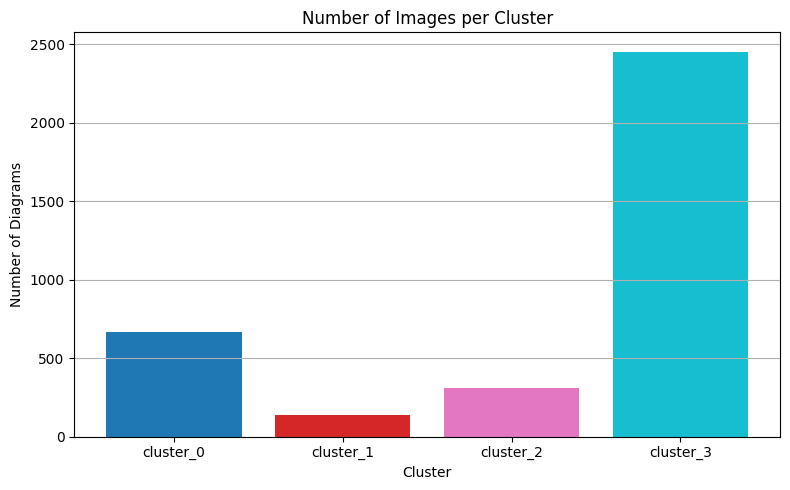

<Figure size 640x480 with 0 Axes>

In [408]:
# Cluster sizes 
cluster_counts = {
    "cluster_0": 669,
    "cluster_1": 138,
    "cluster_2": 311,
    "cluster_3": 2452
}
colors = [cmap(i) for i in range(num_clusters)]

plt.figure(figsize=(8, 5))
plt.bar(cluster_counts.keys(), cluster_counts.values(), color=colors)
plt.xlabel("Cluster")
plt.ylabel("Number of Diagrams")
plt.title("Number of Images per Cluster")
plt.grid(axis='y')
plt.tight_layout()
plt.show()
plt.savefig("clusterdistribution.png")
